In [103]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import keras
import pandas as pd
import numpy as np
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
labels = pd.read_csv('cifar10_Labels.csv', index_col=0)
labels.head()

,label
id,
1,frog
2,truck
3,truck
4,deer
5,automobile


automobile


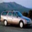

In [3]:
# View an image
img_idx = 5
print(labels.label[img_idx])
Image.open('cifar10/'+str(img_idx)+'.png')

In [174]:
# Splitting data into Train and Test data
from sklearn.model_selection import train_test_split
y_train, y_test = train_test_split(labels.label, test_size=0.3, random_state=42)
train_idx, test_idx = y_train.index, y_test.index # Stroing indexes for later use

In [7]:
# Reading images for training 
temp = []
# cnt = 1
for img_idx in y_train.index:
    img_path = os.path.join('cifar10/', str(img_idx) + '.png')
    img = np.array(Image.open(img_path)).astype('float32')        
    temp.append(img)    
#     print(cnt)
#     cnt+=1
X_train = np.stack(temp)

In [9]:
# Reading images for testing 
temp = []
# cnt = 1
for img_idx in y_test.index:
    img_path = os.path.join('cifar10/', str(img_idx) + '.png')
    img = np.array(Image.open(img_path)).astype('float32')        
    temp.append(img)
#     print(cnt)
#     cnt+=1
X_test = np.stack(temp)

In [10]:
# Normalizing image data
X_train = X_train/255.
X_test = X_test/255.

In [11]:
# One-hot encoding 10 output classes
encode_X = LabelEncoder()
encode_X_fit = encode_X.fit_transform(y_train)
y_train = keras.utils.np_utils.to_categorical(encode_X_fit)

encode_y = LabelEncoder()
encode_y_fit = encode_y.fit_transform(y_test)
y_test = keras.utils.np_utils.to_categorical(encode_y_fit)

In [320]:
# Defining CNN network

num_classes = 10
model = keras.models.Sequential([    
    # Adding first convolutional layer
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(32, 32, 3), name='Conv_1'), 
    # Normalizing the parameters from last layer to speed up the performance (optional)
    keras.layers.BatchNormalization(name='BN_1'),
    # Adding first pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_1'),
    # Adding second convolutional layer
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', 
                        kernel_regularizer=keras.regularizers.l2(0.001), name='Conv_2'),    
    keras.layers.BatchNormalization(name='BN_2'),
    # Adding second pooling layer
    keras.layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_2'),
    # Flattens the input
    keras.layers.Flatten(name='Flat'),
    # Fully-Connected layer
    keras.layers.Dense(num_classes, activation='softmax', name='pred_layer')    
])

In [323]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 32, 32, 32)        128       
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 16, 16, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 16, 16, 64)        18496     
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 16, 16, 64)        256       
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 8, 8, 64)          0         
_________________________________________________________________
Flat (Flatten)               (None, 4096)              0         
__________

In [324]:
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

In [102]:
cpfile = r'CIFAR10_checkpoint.hdf5' # Weights to be stored in HDF5 format
cb_checkpoint = keras.callbacks.ModelCheckpoint(cpfile, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
epochs = 5
model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, callbacks=[cb_checkpoint])

Train on 28000 samples, validate on 7000 samples
Epoch 1/5
28000/28000 [==============================] - 379s 14ms/step - loss: 1.7326 - acc: 0.4736 - val_loss: 1.7605 - val_acc: 0.4581

Epoch 00001: val_acc improved from -inf to 0.45814, saving model to CIFAR10_checkpoint.hdf5
Epoch 2/5
28000/28000 [==============================] - 351s 13ms/step - loss: 1.2379 - acc: 0.6019 - val_loss: 1.7944 - val_acc: 0.4793

Epoch 00002: val_acc improved from 0.45814 to 0.47929, saving model to CIFAR10_checkpoint.hdf5
Epoch 3/5
28000/28000 [==============================] - 353s 13ms/step - loss: 1.0563 - acc: 0.6564 - val_loss: 1.2411 - val_acc: 0.6099

Epoch 00003: val_acc improved from 0.47929 to 0.60986, saving model to CIFAR10_checkpoint.hdf5
Epoch 4/5
28000/28000 [==============================] - 379s 14ms/step - loss: 0.9514 - acc: 0.6893 - val_loss: 1.3454 - val_acc: 0.5811

Epoch 00004: val_acc did not improve
Epoch 5/5
28000/28000 [==============================] - 392s 14ms/step - lo

In [234]:
# << DeprecationWarning: The truth value of an empty array is ambiguous >> can arise due to a NumPy version higher than 1.13.3.
# The issue will be updated in upcoming version.
pred = encode_y.inverse_transform(model.predict_classes(X_test[:10])) 
act = encode_y.inverse_transform([np.argmax(x) for x in y_test[:10]])

res = pd.DataFrame([pred, act]).T
res.columns = ['predicted', 'actual']
res

,predicted,actual
0,truck,horse
1,ship,ship
2,ship,airplane
3,frog,frog
4,automobile,automobile
5,frog,frog
6,ship,ship
7,airplane,airplane
8,frog,frog
9,ship,dog


## CNN Conv and MaxPool Layers' filters visualization
- Provide an absolute path for both `temp_folder` and `input_folder` 
- Make sure to put test images inside `img` folder
- Make sure to create an empty `tmp` folder
- The visualization will start on `http://localhost:5000`
- Proceed by clicking each layer sequentially, halt until the images for a clicked layer are generated/saved in `tmp` folder.
- Interrupt the kernel to stop the execution.

In [64]:
from quiver_engine import server # pip install quiver_engine | for CNN layer's filters visualization.
server.launch(model, temp_folder='/Desktop/tmp', 
              input_folder='/Desktop/img') 

## CNN Dense layer visualization

In [285]:
from vis.visualization import visualize_saliency, visualize_cam, overlay
from vis.utils import utils

In [244]:
# Indexes of categories for our model
classes = encode_y.inverse_transform(np.arange(10))
classes

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype=object)

From `res` dataframe, pick an index where `predicted` class is same as `actual` class.
Say index `6` for `ship`

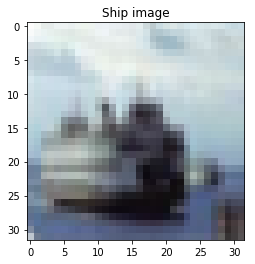

In [282]:
# Fetching the ship image
ship_img = utils.load_img('cifar10/'+str(test_idx[6])+'.png') # can use Image.open() also.
plt.imshow(ship_img)
plt.title('Ship image')
plt.show()

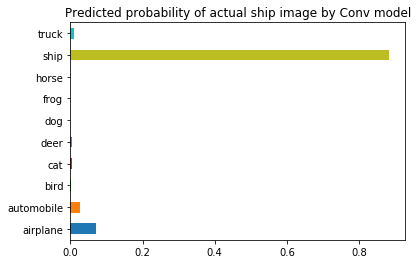

In [278]:
# Predicting the probability for each of the class
ship_prob = model.predict(X_test[6:7]).ravel().copy()
pd.Series(ship_prob, index=classes).plot.barh()
plt.title('Predicted probability of actual ship image by Conv model')
plt.show()

To visualize activation over final dense layer outputs, we need to switch the softmax activation out for linear since gradient of output node will depend on all the other node activations

In [327]:
# Utility to search for layer index by name. 
layer_idx = utils.find_layer_idx(model, 'pred_layer')

# Swap softmax with linear
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)

### 1. Saliency map
Saliency maps clarifies which part does our model focuses on to get prediction.

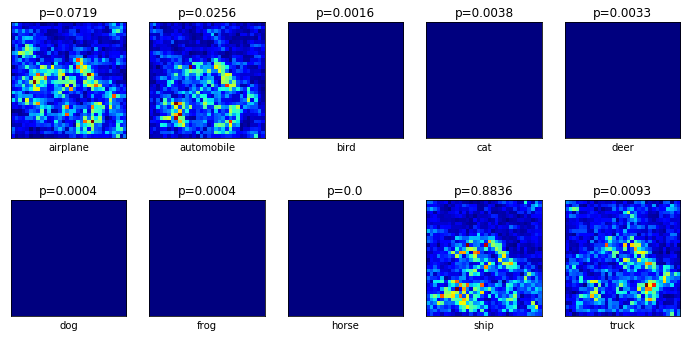

In [284]:
plt.figure(figsize=(12,6))
for i in range(len(classes)):
    plt.subplot(2, 5, i + 1)
    grads = visualize_saliency(model, layer_idx, filter_indices=i, seed_input=ship_img, backprop_modifier='guided')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(classes[i])
    plt.title('p=' + str(np.round(ship_prob[i], 4)))
    plt.imshow(grads, cmap='jet')
plt.show()

As shown in probability graph only first two and last two nodes are active, leaving center 6 almost dead. The second last node meant for `ship` has the highest probability and as seen in above plot only emphasize on region of ship. Other 3 active nodes includes noise and thus reduced probability.

### 2. Class activation maps or Grad-cam
These contain more detail since they use Conv or Pooling features that contain more spatial detail which is lost in Dense layers. The only additional detail compared to saliency is the `penultimate_layer_idx`. This specifies the pre-layer whose gradients should be used.

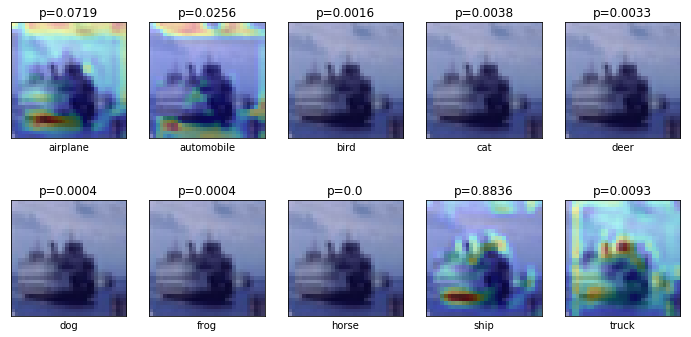

In [328]:
plt.figure(figsize=(12,6))
for i in range(len(classes)):
    plt.subplot(2, 5, i + 1)
    cam_grads = visualize_cam(model, layer_idx, filter_indices=i, seed_input=ship_img, backprop_modifier='guided',
                             penultimate_layer_idx=utils.find_layer_idx(model, 'BN_2'))# batch_normalization_14
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(classes[i])
    plt.title('p=' + str(np.round(ship_prob[i], 4)))
    plt.imshow(overlay(cam_grads, ship_img, alpha=0.3))
plt.show()

The ninth subplot constitute of a contour plot overlayed over original image which captures ship structure better than other three countour plots which are heavily affected by noise.  
Center six nodes are almost dead so no countour plot.